In [122]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from matplotlib.animation import FuncAnimation

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap

from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

import diurnal_config

# from diurnal_utils import *
from fetch_model_helper import *
%run model_by_model_analysis_helper.py
%run diurnal_utils.py

font = {'weight' : 'bold',
        'size'   : 13}
label_fontdict = {'weight' : 'bold',
        'size'   : 13}
title_fontdict = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)


In [141]:
rel_data_dir = '/export/data1/cchristo/'
save_figs_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/'
save_figs_animation = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/animation/'

input_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5/' #GFDL-ESM2M/'
input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6/' #GFDL-ESM4/'
input_data_dir_gpm = rel_data_dir  + 'diurnal_analysis_results/GPM_bin_pt2_hr_15_yr_round_final/'
land_sea_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_regridded/GFDL-CM4_grid/GLDAS_rg_gfdl_cm4.nc'
regrid_weights_dir = rel_data_dir + 'regridding_weights/'

In [89]:
os.listdir(input_data_dir_gpm)

['2000-06_2016-06_precip_diurnal_means.nc', '2000-06_2016-06_precip.nc']

In [90]:
# ds_gpm = xr.open_dataset(input_data_dir_gpm +  '2000-06_2010-06_precip.nc')

ds_gpm_hourly_means_season = xr.open_dataset(input_data_dir_gpm +  '2000-06_2016-06_precip_diurnal_means.nc')
ds_gpm_hourly_means = ds_gpm_hourly_means_season.mean(dim = 'season')
time = ds_gpm_hourly_means['time'].values

# ds_land_sea = xr.open_dataset(land_sea_mask)
# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
# df_gpm = ds_gpm.to_dataframe()
# df_gpm_means = ds_gpm_hourly_means.to_dataframe()

# ds_gpm_hourly_means['land_sea_mask'] 

In [24]:
# ds_gpm_hourly_means[ds_gpm_hourly_means['time.hours']]
# ds_gpm_hourly_means.sel(time = range(0,25))
# ds_gpm_hourly_means

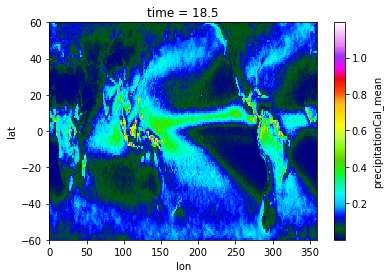

In [91]:
ds_gpm_hourly_means.isel(time = 36)['precipitationCal_mean'].plot.imshow(cmap = plt.get_cmap('gist_ncar'))

/home/cchristo/proj_tapio/diurnal_research/diurnal_utils.py:476: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = figsize)


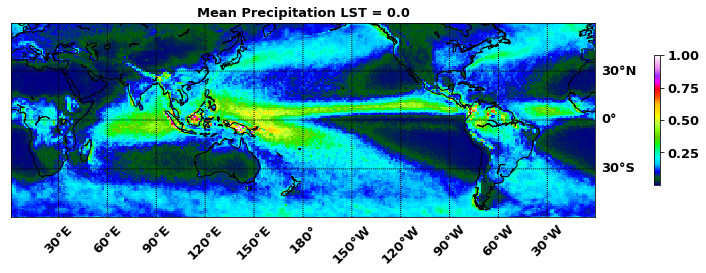

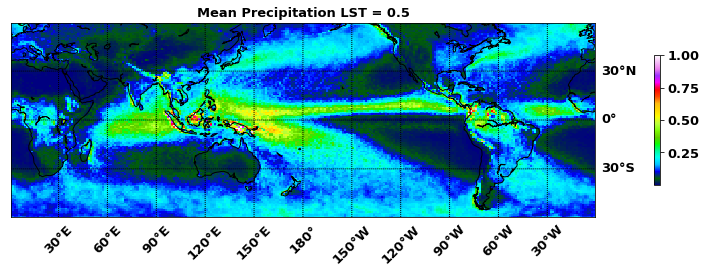

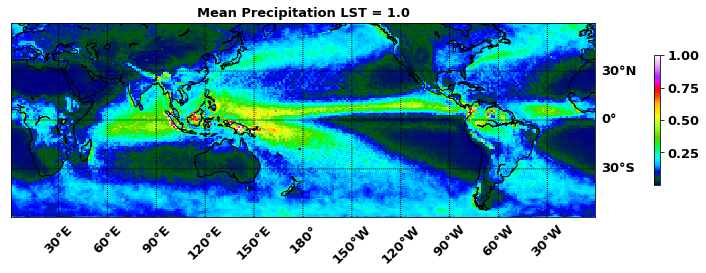

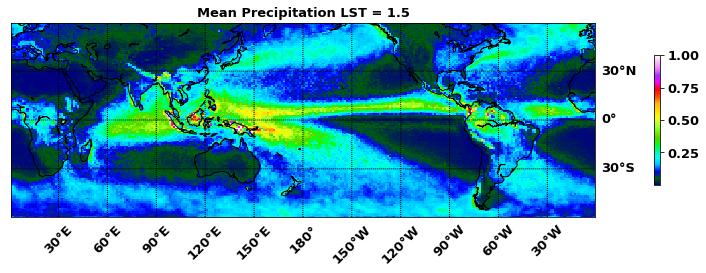

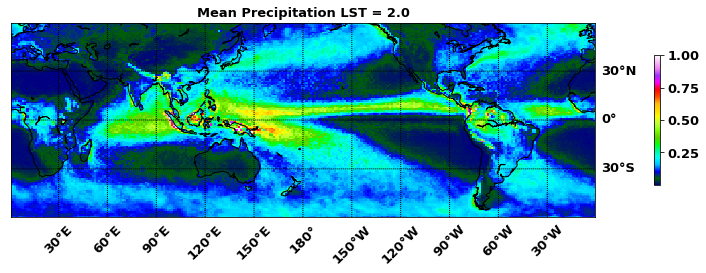

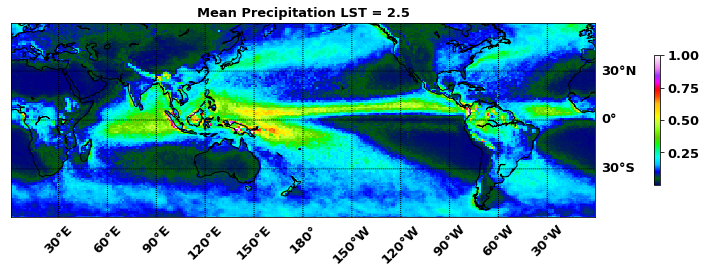

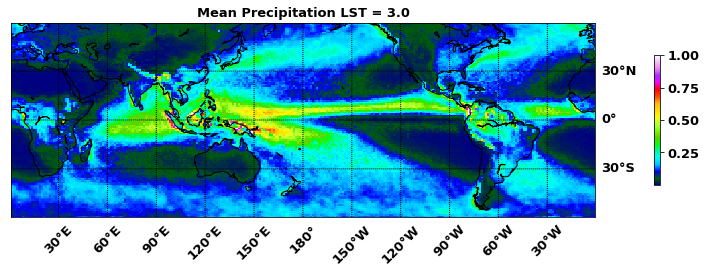

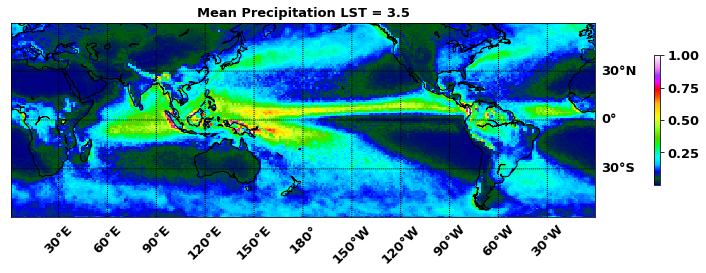

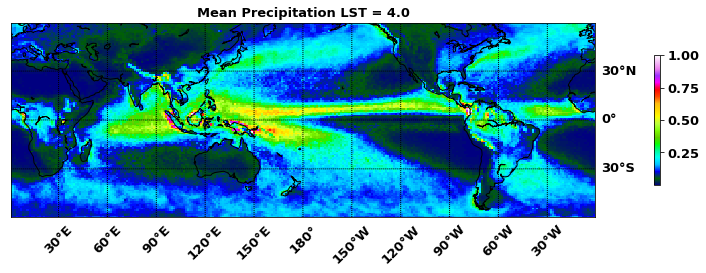

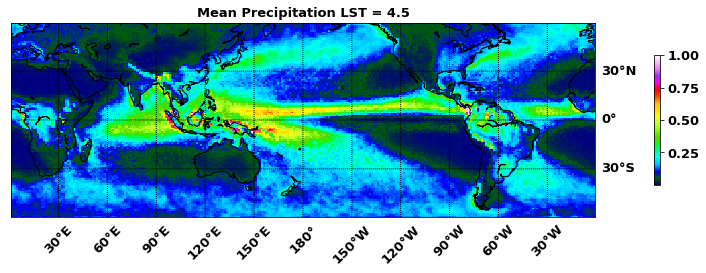

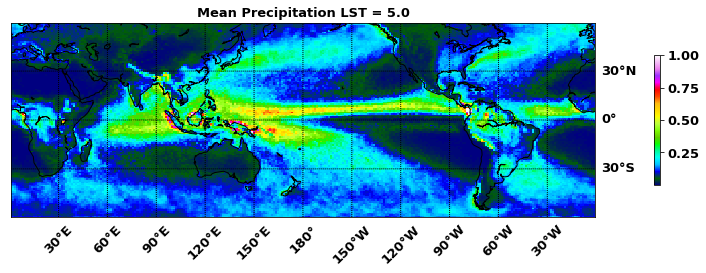

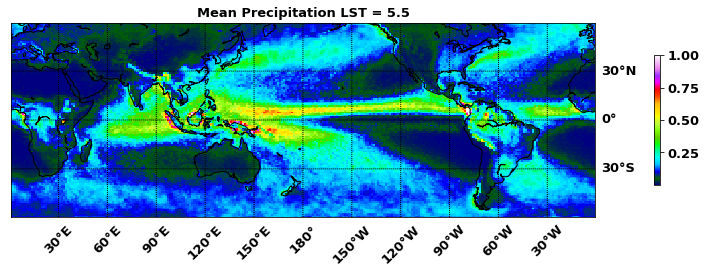

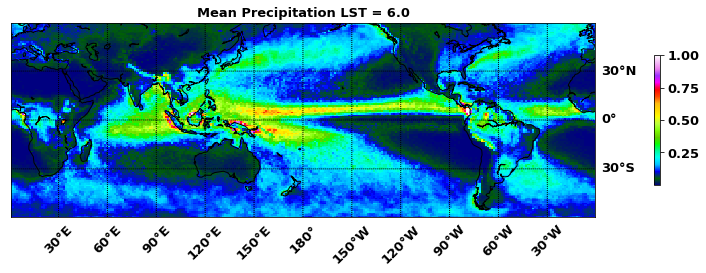

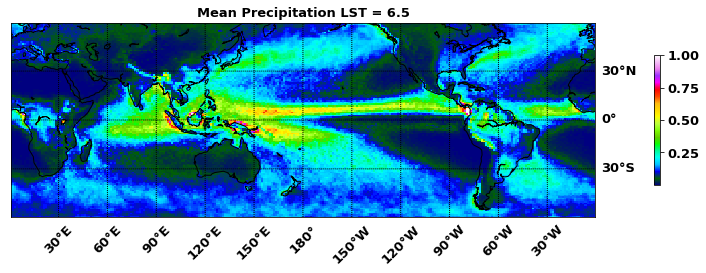

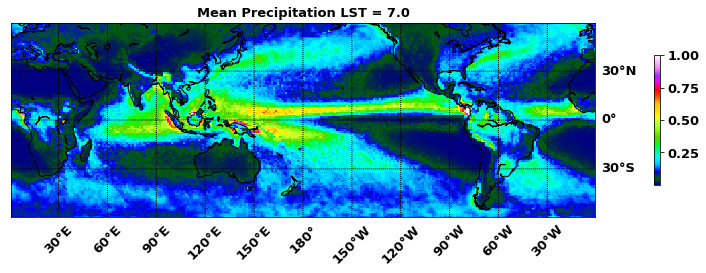

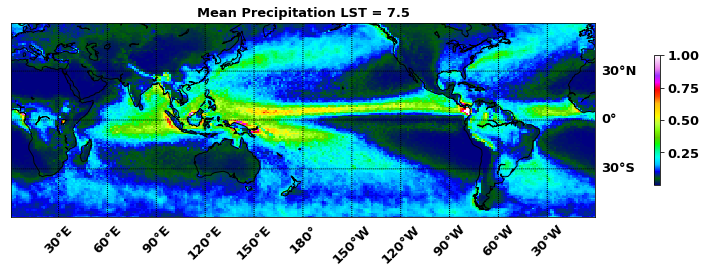

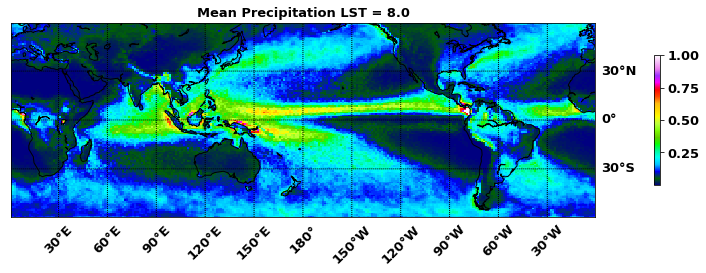

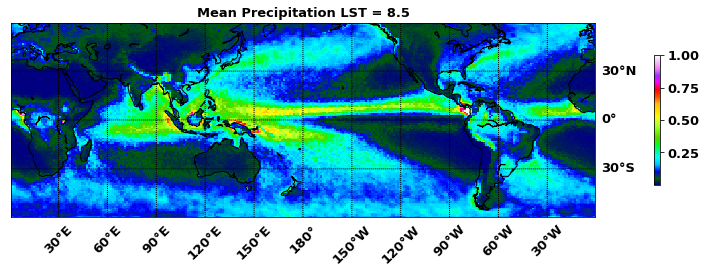

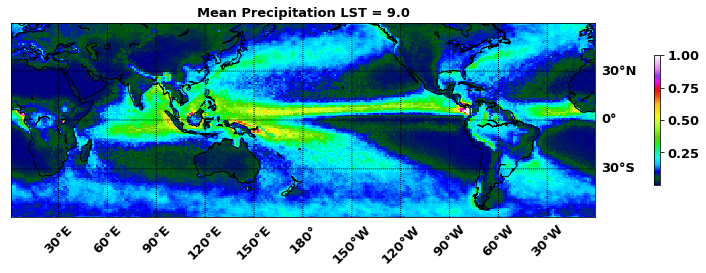

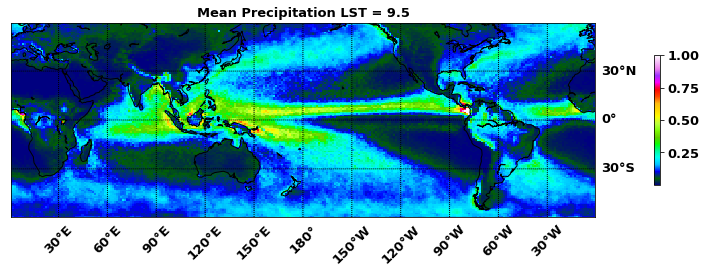

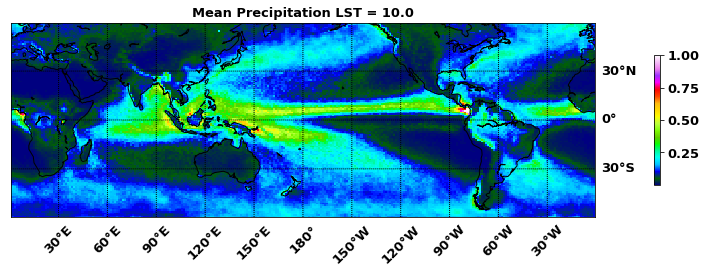

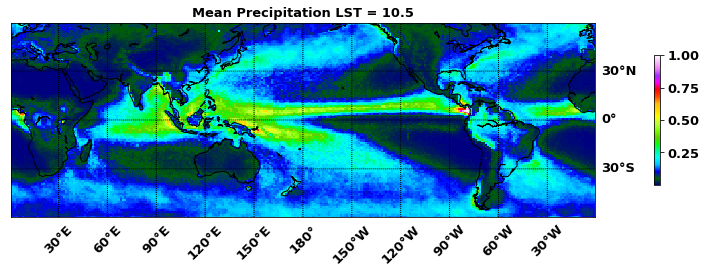

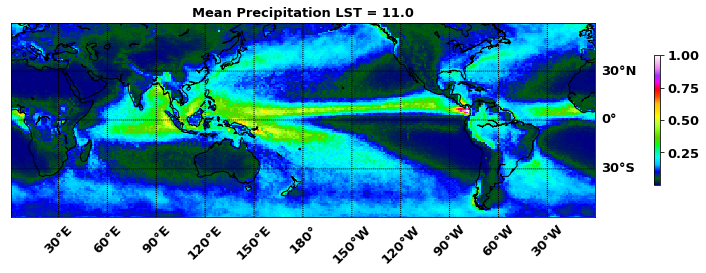

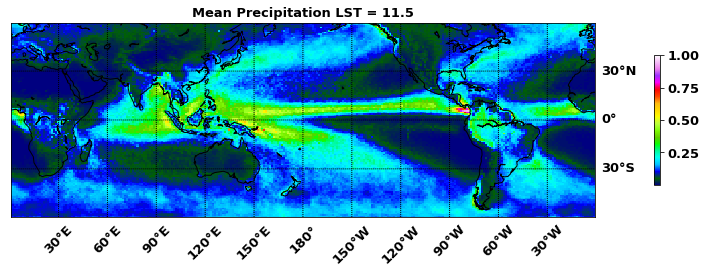

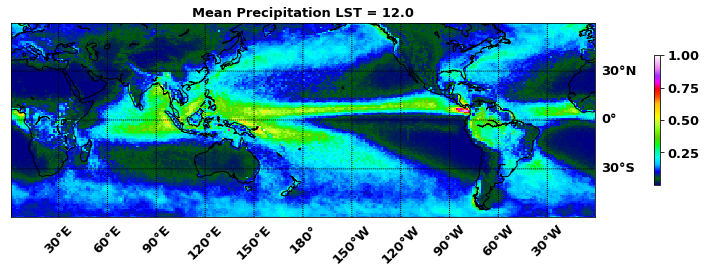

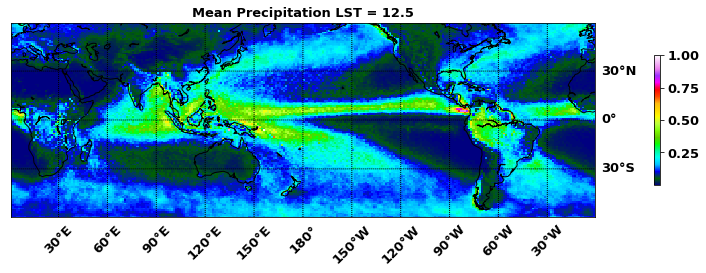

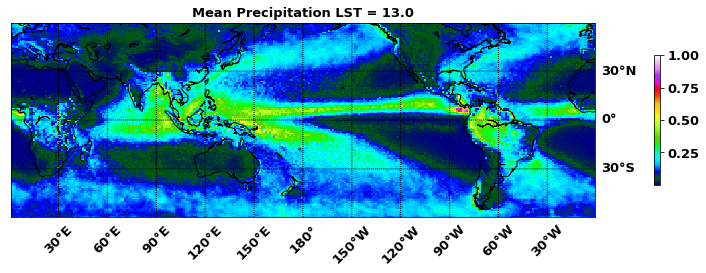

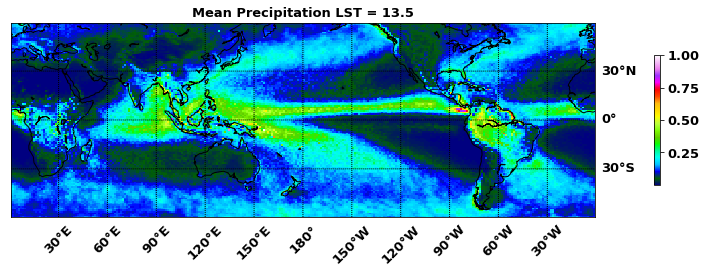

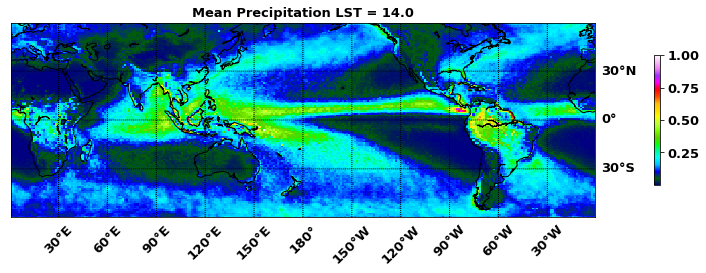

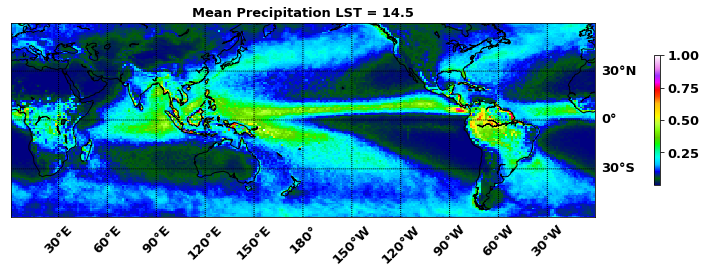

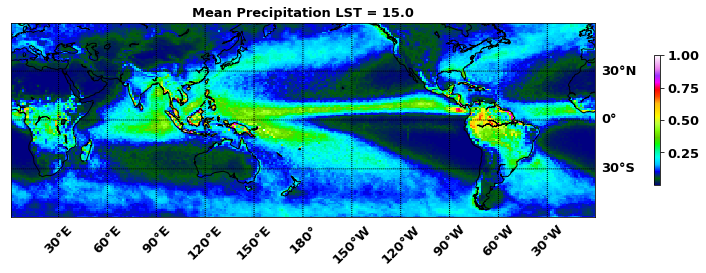

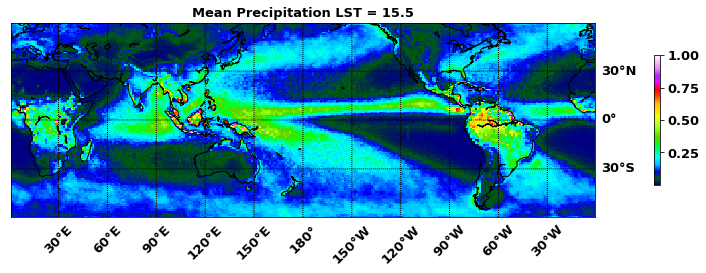

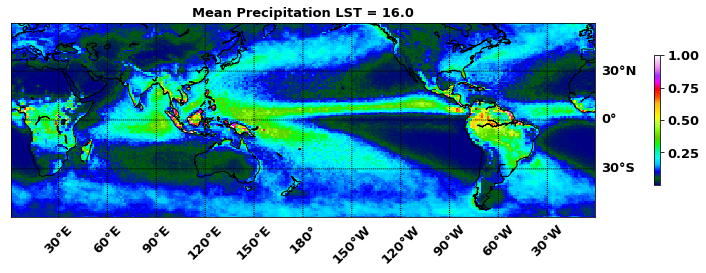

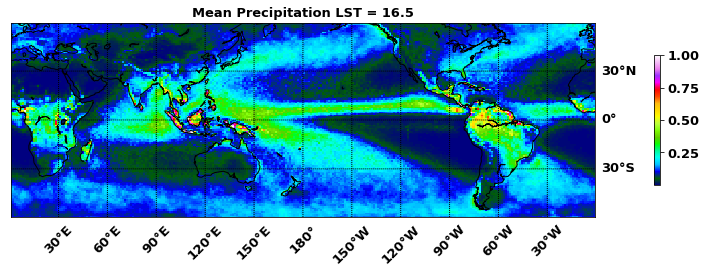

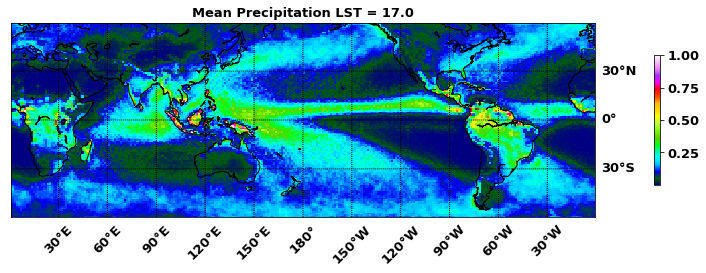

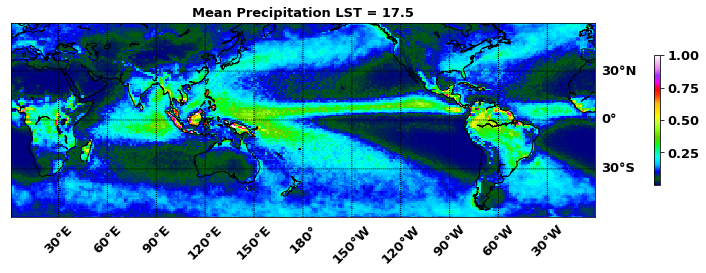

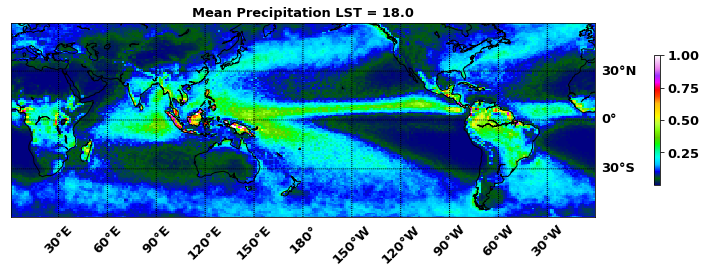

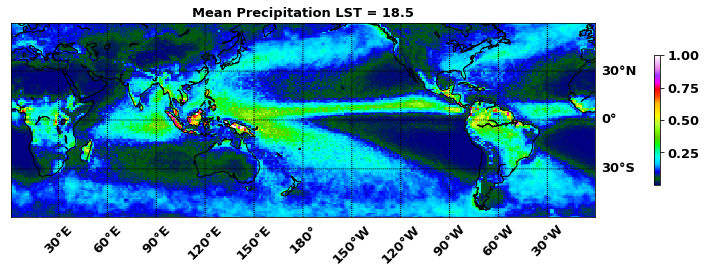

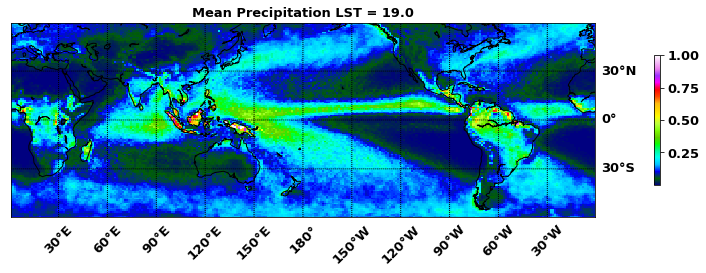

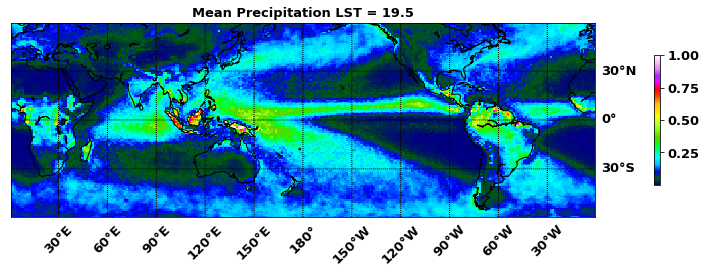

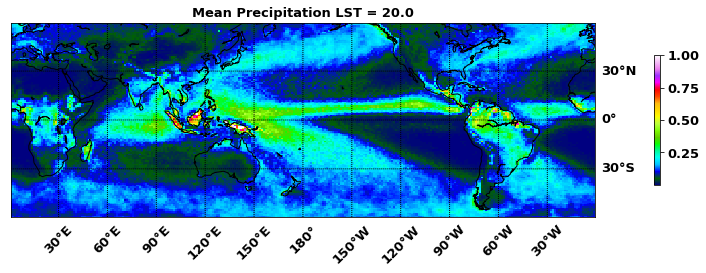

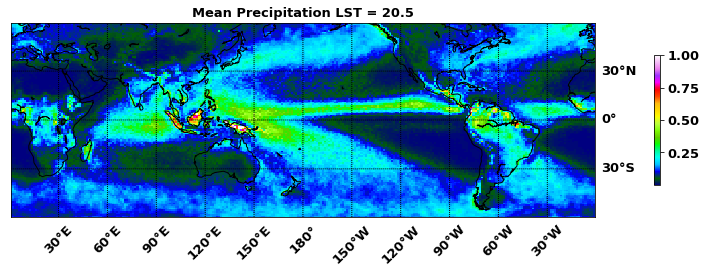

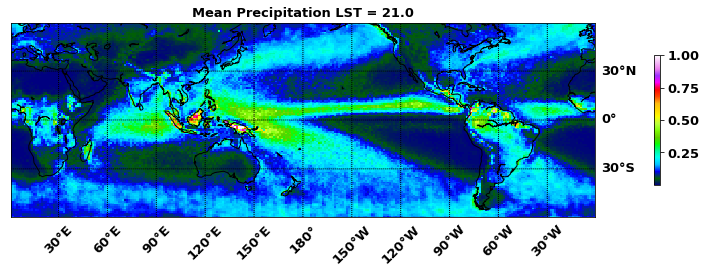

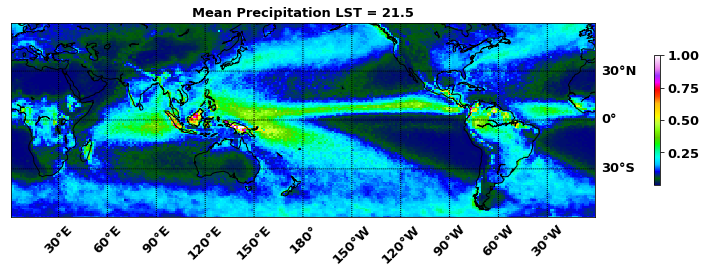

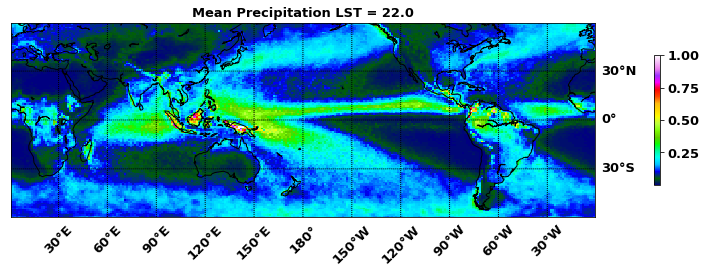

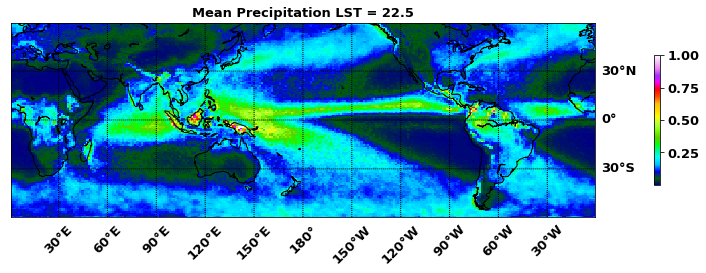

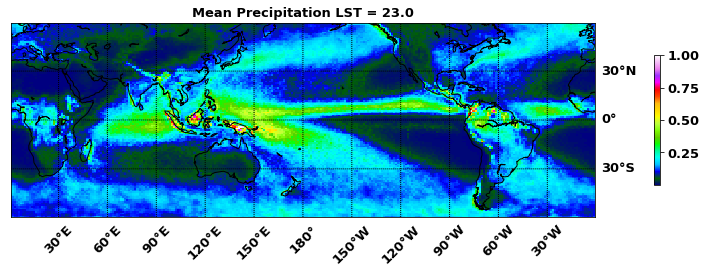

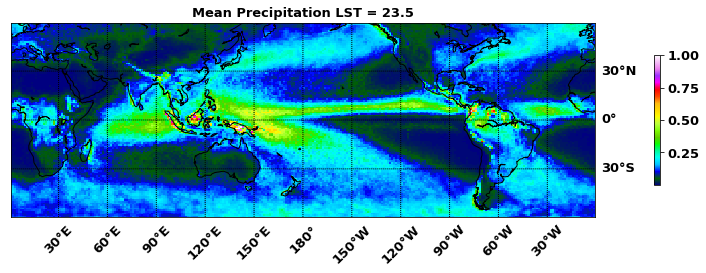

In [143]:

time_i = 36
for time_i in range(48):
    make_single_plot(ds_gpm_hourly_means.isel(time = time_i)['precipitationCal_mean'],
                    cmap = plt.get_cmap('gist_ncar'),
                    title = 'Mean Precipitation LST = ' + str(time_i*0.5),
                    vmax = 1,
                    figsize = (10,12))

    plt.savefig(save_figs_animation + 'precip_hr{:03d}.png'.format(time_i/2),dpi = 300)

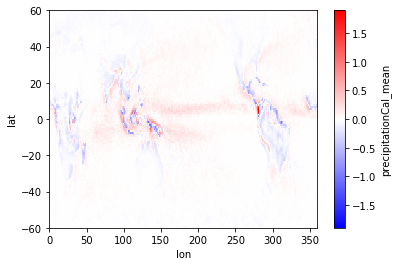

In [81]:
(ds_gpm_hourly_means.isel(time = 12) - ds_gpm_hourly_means.isel(time = 36))['precipitationCal_mean'].plot.imshow(cmap = plt.get_cmap('bwr'))

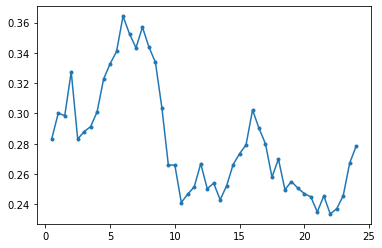

In [54]:
ts_loc = ds_gpm_hourly_means.sel(lat = 40, lon = 300, method = 'nearest')['precipitationCal_mean'].values
plt.plot(ds_gpm_hourly_means.time.values, ts_loc, '.-')

<xarray.DataArray 'time' (time: 48)>
array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5, 12. ,
       12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. , 17.5, 18. ,
       18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. ])
Coordinates:
  * time     (time) float64 0.5 1.0 1.5 2.0 2.5 3.0 ... 22.0 22.5 23.0 23.5 24.0

# Clustering

In [8]:
X_raw = ds_gpm_hourly_means['precipitationCal_mean'].values

In [9]:
n_cols = X_raw.shape[1]*X_raw.shape[2]
X = scale(X_raw.reshape(X_raw.shape[0], n_cols).T, with_mean = True, with_std=False)
# X = scale(X_raw.reshape(X_raw.shape[0], n_cols).T, with_mean = True, with_std=True)
# X = X_raw.reshape(X_raw.shape[0], n_cols).T


print(X.shape)
print(X_raw.shape)

(34560, 48)
(48, 120, 288)


In [11]:
# ds_gpm_hourly_means_season['precipitationCal_mean'].isel(season = 0).isel(lat = 40, lon = 40).plot()

In [18]:
# ds_gpm['phase_season'].isel(season = 2).plot.imshow(cmap = plt.get_cmap('twilight'))

# Perform Kmeans Clustering

In [29]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

KMeans(n_clusters=5)

In [30]:
cluster_ind = kmeans.predict(X)
cluster_centers = kmeans.cluster_centers_
# dir(kmeans)

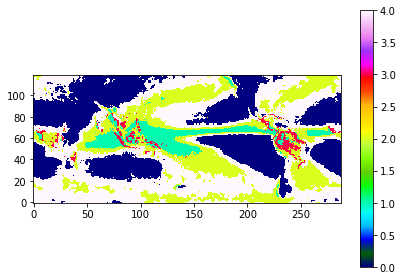

In [31]:
cluster_ind_grid = cluster_ind.reshape(X_raw.shape[1], X_raw.shape[2])
# plt.imshow(cluster_ind_grid, origin = 'lower', cmap = plt.get_cmap('Set1'))
plt.imshow(cluster_ind_grid, origin = 'lower', cmap = plt.get_cmap('gist_ncar'))
plt.colorbar()
plt.tight_layout()
# plt.axis([200, 250,70,90])

In [61]:
cluster_ind_grid_da = xr.DataArray(cluster_ind_grid, dims = ('lat','lon'), coords = {'lat': ds_gpm['lat'].values,
                                                              'lon': ds_gpm['lon'].values})

<xarray.Dataset>
Dimensions:        (lat: 120, lon: 288, season: 4, time: 1)
Coordinates:
  * season         (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lon            (lon) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * lat            (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
  * time           (time) datetime64[ns] 2000-01-01
Data variables:
    mu_season      (season, lat, lon) float64 0.1021 0.09734 ... 0.2238 0.2041
    sigma_season   (season, lat, lon) float64 0.02243 0.02107 ... 0.04441 0.031
    ampl_season    (season, lat, lon) float64 0.01606 0.0191 ... 0.03889 0.0165
    phase_season   (season, lat, lon) float64 0.3005 24.0 24.0 ... 21.86 24.0
    land_sea_mask  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

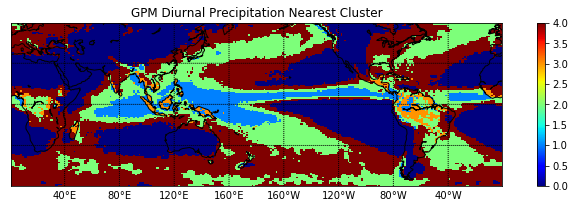

In [71]:
make_single_plot(cluster_ind_grid_da, 
                 title = r'GPM Diurnal Precipitation Nearest Cluster',
                 cmap = plt.get_cmap('jet'))
plt.tight_layout()
plt.savefig(save_figs_dir + 'misc/' + 'cluster_grid.png', dpi = 300)

In [66]:
# ds_gpm_hourly_means

In [354]:
# ds_gpm_hourly_means.sel(lat = 80, lon = 228, method = 'nearest')['precipitationCal_mean'].plot()
# plt.grid()

In [355]:
# ds_gpm_hourly_means.sel(lat = 80, lon = 232, method = 'nearest')['precipitationCal_mean'].plot()
# plt.grid()

In [317]:
# ds_gpm_hourly_means_season

In [356]:
# ds_gpm_hourly_means_season.sel(lat = 80, lon = 228, method = 'nearest').isel(season= 3)['precipitationCal_mean'].plot()

# Plot Cluster Centers

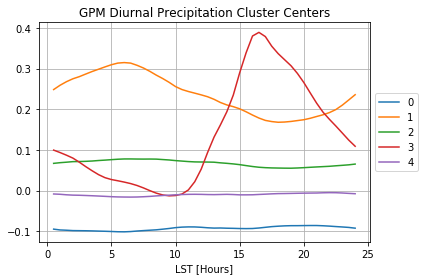

In [72]:
plt.figure()
plt.title('GPM Diurnal Precipitation Cluster Centers')
for ii in range(cluster_centers.shape[0]):
    plt.plot(time, cluster_centers[ii,:], label = str(ii))
ax = plt.gca()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.5))
plt.xlabel('LST [Hours]')
plt.grid()
plt.tight_layout()
plt.savefig(save_figs_dir + 'misc/' + 'cluster_centers.png', dpi = 300)

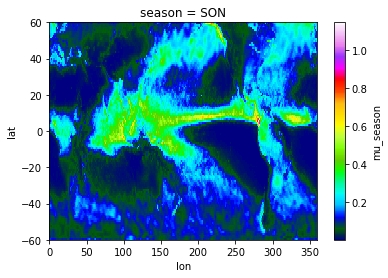

In [34]:
ds_gpm['mu_season'].isel(season = 3).plot.imshow(cmap = plt.get_cmap('gist_ncar'))
# plt.colorbar()

# Perform Kmeans clustering by season

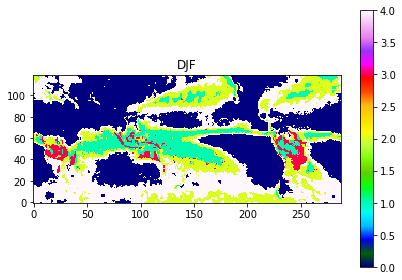

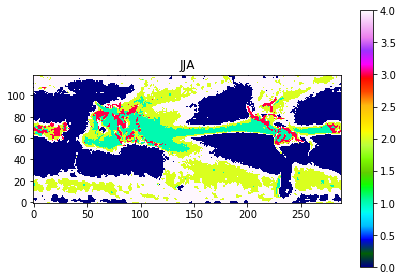

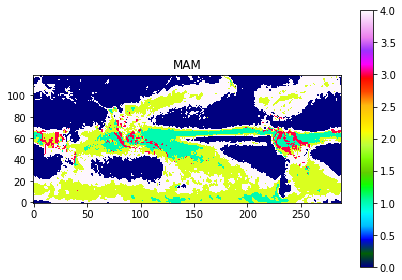

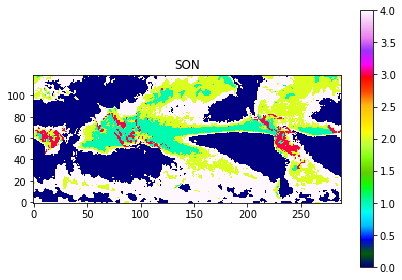

In [35]:
ds_season = ds_gpm_hourly_means_season.groupby('season')
for season_i, season_ds in ds_season:
    
    # kmeans clustering 
    X_raw_season = season_ds['precipitationCal_mean'].values
    
    n_cols = X_raw_season.shape[1]*X_raw_season.shape[2]
    X_season = scale(X_raw_season.reshape(X_raw_season.shape[0], n_cols).T, with_mean = True, with_std=False)
    
    
#     kmeans = KMeans(n_clusters=7)
#     kmeans.fit(X)
    
    cluster_ind_season = kmeans.predict(X_season)
    cluster_centers_season = kmeans.cluster_centers_
    
    # plot
    
    cluster_ind_grid_season = cluster_ind_season.reshape(X_raw_season.shape[1], X_raw_season.shape[2])
    plt.figure()
    plt.imshow(cluster_ind_grid_season, origin = 'lower', cmap = plt.get_cmap('gist_ncar'))
    plt.title(season_i)
    plt.colorbar()
    plt.tight_layout()

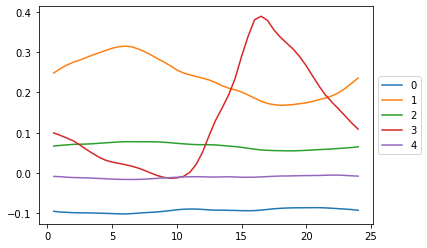

In [36]:
for ii in range(cluster_centers.shape[0]):
    plt.plot(time, cluster_centers[ii,:], label = str(ii))
ax = plt.gca()
ax.legend(loc = 'center left', bbox_to_anchor=(1,0.5))

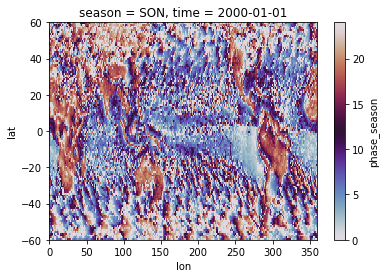

In [284]:
# ys
# ds_i.to_dataframe

# list(objs.values())[0]
# df
ds_gpm['phase_season'].isel(season = 3).plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)

(0, 0.5)

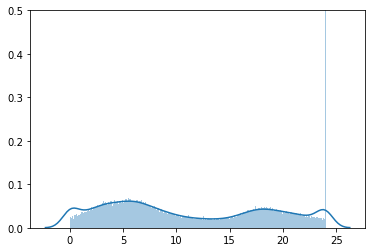

In [269]:
sns.distplot(df_gpm['phase_season'].values, label = 'Water', bins = 500)
plt.ylim([0, 0.5])


In [14]:
ds_gpm

<xarray.Dataset>
Dimensions:        (lat: 120, lon: 288, season: 4)
Coordinates:
  * season         (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lon            (lon) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * lat            (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
    time           datetime64[ns] 2000-01-01
Data variables:
    mu_season      (season, lat, lon) float64 0.05104 0.04867 ... 0.1119 0.1021
    sigma_season   (season, lat, lon) float64 0.05365 0.05108 ... 0.117 0.1053
    ampl_season    (season, lat, lon) float64 0.01687 0.01999 ... 0.01664
    phase_season   (season, lat, lon) float64 0.062 24.0 24.0 ... 21.55 24.0
    land_sea_mask  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [295]:
# input_data_dir = '/export/data1/cchristo/diurnal_analysis_results/GPM/'
# input_data_dir = '/export/data1/cchristo/diurnal_analysis_results/GPM/'

ds = xr.open_dataset(input_data_dir  + '2000-06_2010-06_precip.nc')
ds_diurnal_means = xr.open_dataset(input_data_dir + '2000-06_2010-06_precip_diurnal_means.nc')

NameError: name 'input_data_dir' is not defined

In [19]:
ds

<xarray.Dataset>
Dimensions:       (lat: 120, lon: 288, season: 4)
Coordinates:
  * season        (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lon           (lon) float64 0.625 1.875 3.125 4.375 ... 356.9 358.1 359.4
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
Data variables:
    mu_season     (season, lat, lon) float64 ...
    sigma_season  (season, lat, lon) float64 ...
    ampl_season   (season, lat, lon) float64 ...
    phase_season  (season, lat, lon) float64 ...

In [94]:
ds_diurnal_means.isel(season =0, time = 1)['precipitationCal_mean'].max()

<xarray.DataArray 'precipitationCal_mean' ()>
array(2.13547978)
Coordinates:
    season   <U3 'DJF'
    time     float64 1.0

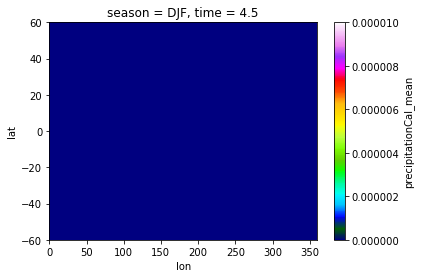

In [286]:
ds_diurnal_means.isel(season =0,lat = 2, lon = 2)['precipitationCal_mean'].plot()

NameError: name 'ds_diurnal_means' is not defined

In [287]:
plt.imshow(ds.isel(season = 2)['phase_season'].values, origin = 'lower',
           cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)
plt.axis([100,140, 10, 30])
plt.colorbar()

NameError: name 'ds' is not defined

In [28]:
# make_four_panel(ds , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
#                 vmin = 0, vmax = 24, 
#                 cmap = plt.get_cmap('twilight'),
#                 title = r'$\Phi$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= None)

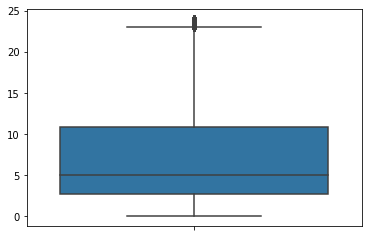

In [185]:
sns.boxplot(y = ds['phase_season'].values)

In [115]:
input_d_dir = '/export/data1/cchristo/diurnal_analysis_results/GPM_cp/'
ds_i = xr.open_dataset(input_d_dir + '2000-06_2010-06_precip.nc')
ds_i_means = xr.open_dataset(input_d_dir + '2000-06_2010-06_precip_diurnal_means.nc')

seas_ii = 0
field_ii = 'phase_season'

ds_i = ds_i.isel(season = seas_i)[field_ii]
ds_i_means = ds_i_means.isel(season = seas_i)['precipitationCal_mean']

In [289]:
# input_data_dir = '/export/data1/cchristo/diurnal_analysis_results/CMIP5/GFDL-ESM2M/'
model_n =  'GFDL-ESM2G/'
seas_ii = 0
field_ii = 'phase_season'
# ds_all_cmip5 = xr.open_mfdataset(input_data_dir + '1985-01_2006-01_precip.nc', combine = 'by_coords')
ds_i = xr.open_dataset(input_data_dir_cm5 + model_n + '1985-01_2006-01_precip.nc')
ds_i_means = xr.open_dataset(input_data_dir_cm5 + model_n + '1985-01_2006-01_precip_diurnal_means.nc')

ds_i = ds_i.isel(season = seas_i)[field_ii]
ds_i_means = ds_i_means.isel(season = seas_i)['pr_mean']

NameError: name 'seas_i' is not defined

In [133]:
ds_i

<xarray.DataArray 'phase_season' (lat: 120, lon: 288)>
array([[6.199736e-02, 2.400000e+01, 2.400000e+01, ..., 4.792325e+00,
        2.400000e+01, 1.881135e+00],
       [2.031184e+00, 1.276661e+00, 2.400000e+01, ..., 2.400000e+01,
        2.400000e+01, 2.544816e+00],
       [1.966771e+00, 4.271910e+00, 2.422167e+00, ..., 2.400000e+01,
        2.400000e+01, 2.400000e+01],
       ...,
       [1.023381e+01, 1.169730e+01, 2.400000e+01, ..., 4.628328e+00,
        1.098864e+01, 6.974327e+00],
       [9.929710e+00, 2.170902e+01, 2.388195e+01, ..., 1.066744e+01,
        1.064745e+01, 6.847126e+00],
       [4.899163e+00, 1.588984e+01, 3.495548e+00, ..., 2.530024e-13,
        1.636147e+01, 1.721427e+01]])
Coordinates:
    season   <U3 'DJF'
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * lat      (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 ... 56.5 57.5 58.5 59.5

In [288]:
ds_i.plot.imshow(cmap = plt.get_cmap('twilight'))

NameError: name 'ds_i' is not defined

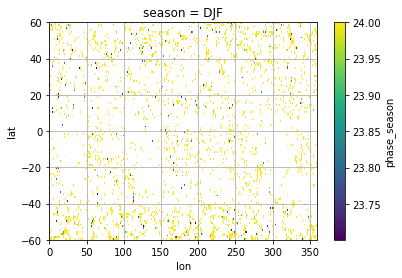

In [164]:
ds_i.where(abs(ds_i - 24) < 0.3).plot.imshow()
plt.grid()
# ds_i


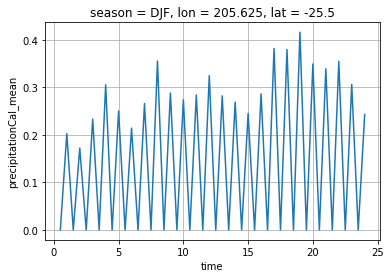

In [155]:
ds_i_means.sel(lat = -26, lon = 205, method = 'nearest').plot()
plt.grid()

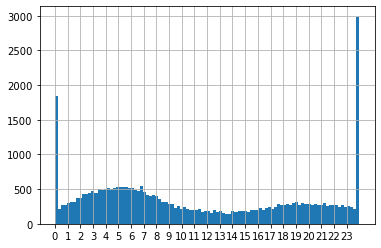

In [159]:
# ds_i['phase_season'].plot(bins = 80)
_ = plt.hist(ds_i.values.flatten(), bins = 100)
plt.xticks(np.arange(0, 24, 1.0))
plt.grid()

In [158]:
input_data_dir = '/export/data1/cchristo/diurnal_analysis_results/GPM_prev/'

os.listdir(input_data_dir)
ds_gpm = xr.open_dataset(input_data_dir  + '2000-06_2001-06_precip.nc')
ds_diurnal_means_gpm = xr.open_dataset(input_data_dir  + '2000-06_2001-06_precip_diurnal_means.nc')

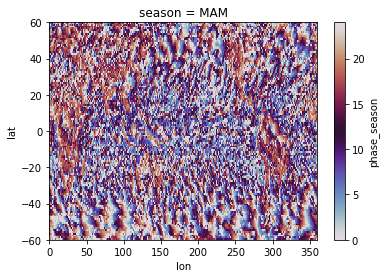

In [174]:
# ds.isel(season = 1)['mu_season'].plot.imshow(cmap = plt.get_cmap('gist_ncar')) 
ds_gpm.isel(season = 2)['phase_season'].plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)